# **Module 6: Descriptive and Predictive Modeling**
## **Exercise 1:** K-Nearest Neighbors in depth **(Digits)**
### **Submitted by:** Jorge de la Torre Garcia (DNI), Lydia Phoebe Amanda Lilius (DNI), Miguel Galán Cisneros (DNI), Vitor Oliveira de Souza (Z0963220P)
### **Date:** 25/02/2024

In [1]:
import pandas as pd
import numpy as np
import sklearn
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.datasets import load_digits

In [2]:
# Load dataset from sklearn datasets
dataset = load_digits()

In [3]:
# Get input data from dataset
X = pd.DataFrame(dataset.data)
# Get feature names
X.columns = dataset.feature_names
# Get output labels
y = pd.DataFrame(dataset.target)
y.columns = ['target']

In [4]:
# Take a look in input data
X.head()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


In [5]:
X.shape, y.shape

((1797, 64), (1797, 1))

In [6]:
# Check the classes distribution
y.groupby('target').size()

target
0    178
1    182
2    177
3    183
4    181
5    182
6    181
7    179
8    174
9    180
dtype: int64

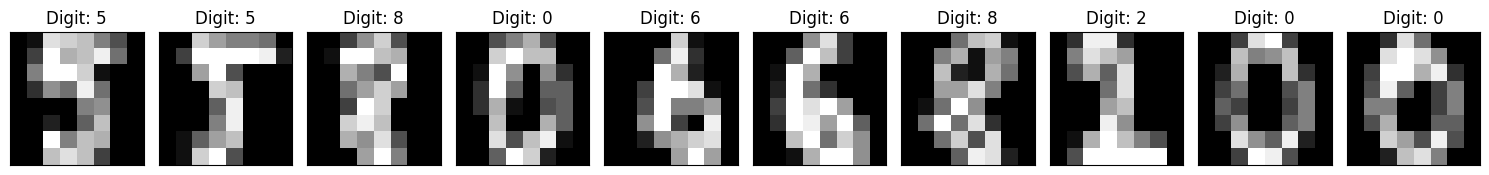

In [7]:
def print_digits(images_index, predict = None):
    # Create a figure for the subplots
    plt.figure(figsize=(15, 15))
    
    for index, image in enumerate(images_index, start=1):
        # Select the digit
        digit = dataset.images[image]
        
        # Create subplot for each digit
        plt.subplot(1, n_images, index)
        plt.imshow(digit, cmap='gray', interpolation='nearest')
        plt.title(f"Digit: {dataset.target[image]}" if predict is None else f'Digit: {dataset.target[image]} \n Predict: {predict[index-1]}')
        plt.xticks([])
        plt.yticks([])
    
    plt.tight_layout()
    plt.show()

# Lets take a look in the images
import random
# Select random images
n_images = 10
images = [random.randint(0, len(dataset.images) - 1) for _ in range(n_images)]
print_digits(images)



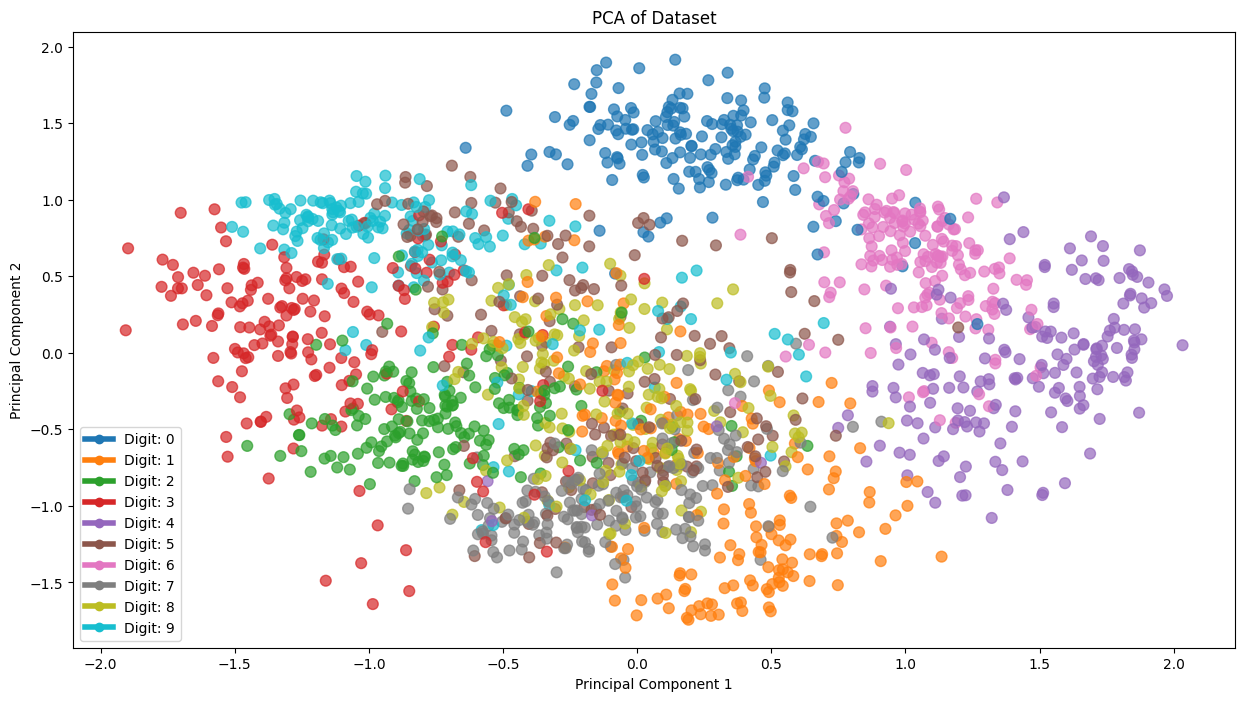

In [8]:
# Visualise the data in 2D using PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib.lines import Line2D
%matplotlib inline


# Create a function because we'll use it later to check the model's results
def print_pca(data, 
              y, 
              highlight_index=None,
              highlight_points=None,
              text='',
              dim_reducer=PCA(n_components=2),
              scaler=MinMaxScaler()
             ):
    
    X_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)
    
    # Perform PCA
    X_pca = dim_reducer.fit_transform(X_scaled)
    X_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'], index=X_scaled.index)
    X_pca['labels'] = [text+str(target) for target in y['target']]

    # Plot the data
    fig, ax = plt.subplots(figsize=(15, 8))
    scatter = ax.scatter(x=X_pca['PC1'],
               y=X_pca['PC2'],
               c=y['target'],
               cmap='tab10',
               s=60,alpha=0.7)

    # Plot highlighted points based on the index list provided
    if highlight_index is not None:

        print(X_pca.loc[highlight_index].index)
        
        highlighted = ax.scatter(x=X_pca['PC1'].loc[highlight_index],
                                 y=X_pca['PC2'].loc[highlight_index],
                                 c='lime', marker='x', s=60, alpha=1)
        # Annotate highlighted points
        for i in highlight_index:
            ax.annotate(X_pca['labels'].loc[i], 
                        (X_pca['PC1'].loc[i], X_pca['PC2'].loc[i]),
                        textcoords="offset points", # Positioning of the text
                        xytext=(0,10), # Distance from the point to the text
                        ha='center', # Horizontal alignment
                       bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='black', alpha=0.5)) # Background box
    
    # Highlight additional points specified directly that are not in the main dataset
    if highlight_points is not None:
        
        # Scale the highlight_points with the same scaled
        highlight_points_scaled = pd.DataFrame(scaler.transform(highlight_points), columns=highlight_points.columns, index=highlight_points.index)
        # Transform using PCA using the same pca transformer
        highlight_points_pca = dim_reducer.transform(highlight_points_scaled)
        
        # Plot the highlighted points
        for point in highlight_points_pca:
            ax.scatter(point[0], point[1], c='gold', edgecolor='black', marker='o', s=60, alpha=1)

    # Custom legend for classes
    classes = list(set(y['target']))
    class_labels = ['Digit: ' + str(cls) for cls in classes]
    colors = [scatter.cmap(scatter.norm(cls)) for cls in classes]
    custom_lines = [Line2D([0], [0], color=colors[i], lw=4, marker='o') for i in range(len(classes))]
    ax.legend(custom_lines, class_labels)
        
    # Set titles and labels
    ax.set_title('PCA of Dataset')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')

print_pca(X,y)

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

# Now we create a splitter to split the data considering the classes
# If we simply split the data randomly, the unbalanced classes could be splitted unevenly in train and test
sss = StratifiedShuffleSplit(n_splits=1,test_size=0.2, random_state=0)

for train_index, test_index in sss.split(X, y):
    Xtrain, ytrain = X.iloc[train_index], y.iloc[train_index]
    Xtest, ytest = X.iloc[test_index], y.iloc[test_index]

Acc (Test): 	0.9806
Kappa (Test): 	0.9784
F1 (Test): 	0.9805
AUC: 		0.9968


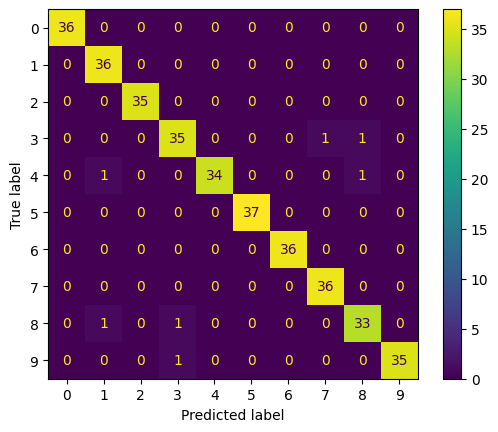

In [10]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, cohen_kappa_score
import matplotlib.pyplot as plt

estimator = Pipeline([('Scaler',MinMaxScaler()),('KNN',KNeighborsClassifier())])

estimator.fit(Xtrain, ytrain.squeeze())

ypred = estimator.predict(Xtest)
yprob = estimator.predict_proba(Xtest)

# Computing and displaying accuracy , cohen_kappa_score and F1 score for the test set
print(f'Acc (Test): \t{accuracy_score(ytest["target"], ypred):.4f}')
print(f'Kappa (Test): \t{cohen_kappa_score(ytest["target"], ypred):.4f}')
print(f'F1 (Test): \t{f1_score(ytest["target"], ypred, average="macro"):.4f}')

# Calculating and printing the ROC AUC score
roc_auc = roc_auc_score(ytest, yprob, multi_class='ovr', average='macro')
print(f'AUC: \t\t{roc_auc:.4f}')

# Generating and displaying the confusion matrix
cm = confusion_matrix(ytest["target"], ypred)
display = ConfusionMatrixDisplay(cm)
display.plot()
plt.show()

In [11]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from datetime import datetime

param_grid = {
    "KNN__n_neighbors": [3, 5, 7, 9],
    "KNN__p": [1, 2, 3, 4, 5],
    "KNN__weights": ["uniform", "distance"],
}

cv_stratified = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

gscv = GridSearchCV(
    estimator=estimator, 
    param_grid=param_grid, 
    scoring="accuracy", 
    cv=cv_stratified, 
    verbose=1
)

start_time = datetime.now()
gscv.fit(Xtrain, ytrain.squeeze())
total_time = datetime.now() - start_time

Fitting 10 folds for each of 40 candidates, totalling 400 fits


In [12]:
print(f"Best parameters found in Grid Search: {gscv.best_params_}")

Best parameters found in Grid Search: {'KNN__n_neighbors': 5, 'KNN__p': 3, 'KNN__weights': 'uniform'}


Total Time: 	0:01:01.997668 seconds
Avg acc (CV):	0.9882
Acc (Test): 	0.9806
Kappa (Test): 	0.9784
F1 (Test): 	0.9806
AUC: 		0.9968


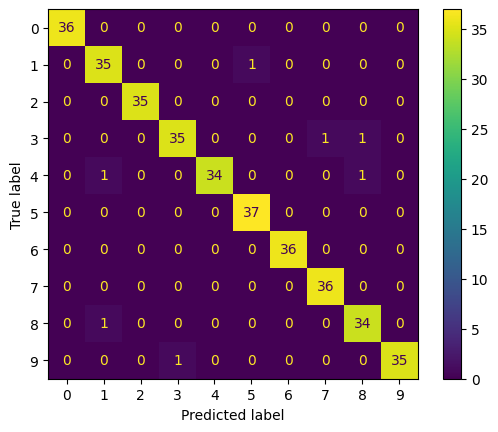

In [13]:
def evaluate_model(predictor):
    # Evaluate the model's performance on the test dataset, focusing on metrics such as accuracy, F1 score, ROC AUC, and the confusion matrix.
    
    # Reporting computational time for model training and grid search
    print(f'Total Time: \t{total_time} seconds')
    
    # Displaying the average accuracy obtained from cross-validation
    print(f"Avg acc (CV):\t{predictor.best_score_:.4f}")
    
    # Fitting the best model found via grid search to the training data
    best_estimator = predictor.best_estimator_
    best_estimator.fit(Xtrain, ytrain['target'])
    
    # Predicting class labels for the test set
    ypred = best_estimator.predict(Xtest)
    
    # Obtaining probability estimates for the test set (used for ROC AUC calculation)
    yprob = best_estimator.predict_proba(Xtest) # Extracting probabilities for the positive class
    
    # Computing and displaying accuracy , cohen_kappa_score and F1 score for the test set
    print(f'Acc (Test): \t{accuracy_score(ytest["target"], ypred):.4f}')
    print(f'Kappa (Test): \t{cohen_kappa_score(ytest["target"], ypred):.4f}')
    print(f'F1 (Test): \t{f1_score(ytest["target"], ypred, average="macro"):.4f}')
    
    # Calculating and printing the ROC AUC score
    roc_auc_score(ytest, yprob, multi_class='ovr', average='macro')
    print(f'AUC: \t\t{roc_auc:.4f}')
    
    # Generating and displaying the confusion matrix
    cm = confusion_matrix(ytest["target"], ypred)
    display = ConfusionMatrixDisplay(cm)
    display.plot()
    plt.show()

evaluate_model(gscv)

In [14]:
big_param_grid = {
    "KNN__n_neighbors": [3, 5, 7, 9, 11],
    "KNN__p": [1, 2, 3, 4, 5, 7],
    "KNN__weights": ["uniform", "distance"],
    "KNN__metric": ['cosine','minkowski']
}

cv_stratified = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

big_gscv = GridSearchCV(
    estimator=estimator, param_grid=big_param_grid, scoring="accuracy", cv=cv_stratified, verbose=1
)

start_time = datetime.now()
big_gscv.fit(Xtrain, ytrain.squeeze())
total_time = datetime.now() - start_time

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


In [15]:
print(f"Best parameters found in big Grid Search: {big_gscv.best_params_}")

Best parameters found in big Grid Search: {'KNN__metric': 'minkowski', 'KNN__n_neighbors': 5, 'KNN__p': 3, 'KNN__weights': 'uniform'}


Total Time: 	0:01:41.434453 seconds
Avg acc (CV):	0.9882
Acc (Test): 	0.9806
Kappa (Test): 	0.9784
F1 (Test): 	0.9806
AUC: 		0.9968


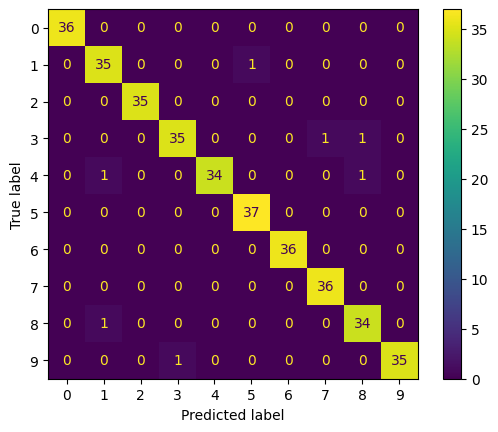

In [16]:
evaluate_model(big_gscv)

Index([1606, 1660, 1118, 87, 1038, 899, 794], dtype='int64')


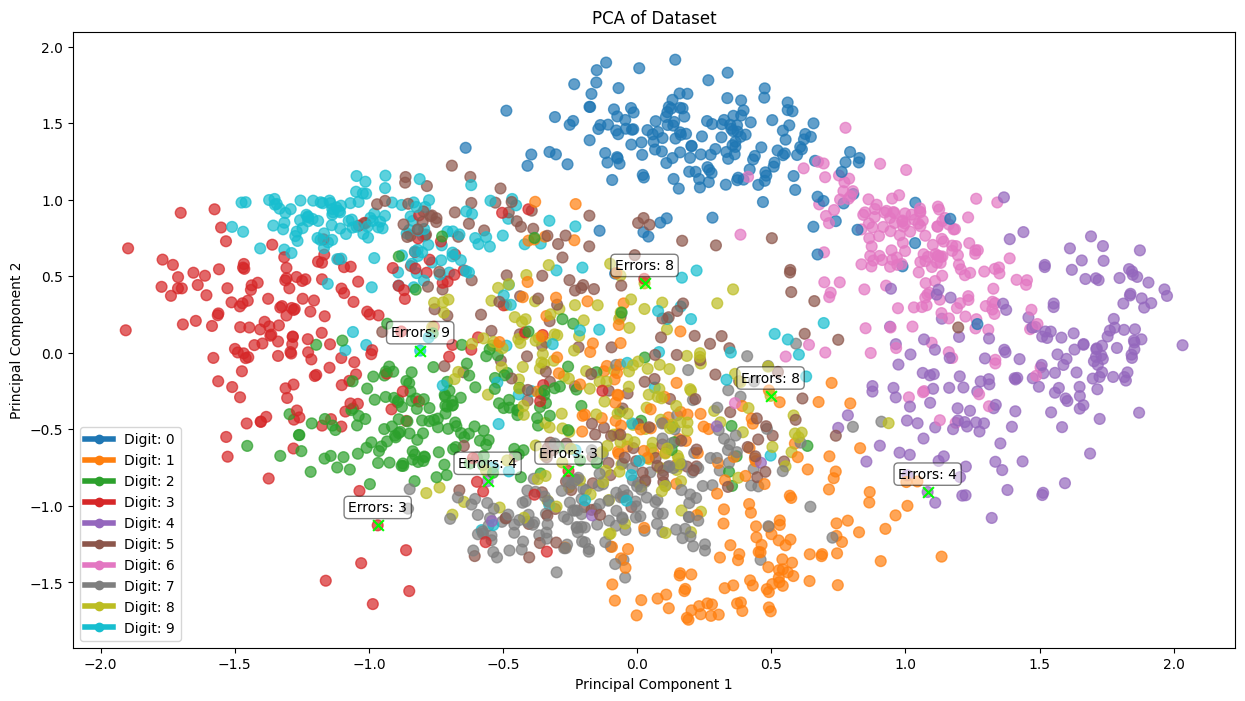

In [17]:
# Let's check graphcally which examples couldn't correctly classified by our model
errors = ytest['target'][ytest['target'] != ypred]
print_pca(X,y,highlight_index=errors.index,text='Errors: ')

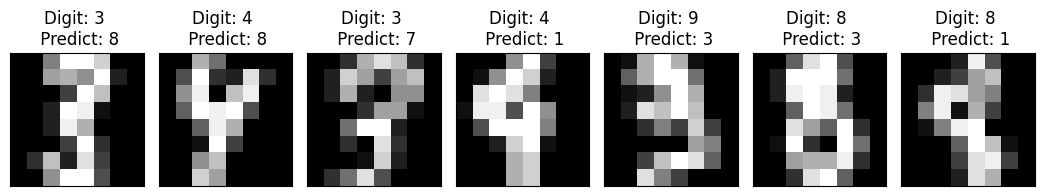

In [19]:
# Now let's take a look in the examples our model is not getting right no matter how good we grid search for the parameters
results = ytest.copy()
results['predict'] = ypred
errors = results[results['target'] != results['predict']]
print_digits(errors.index, errors['predict'].values)

#### **Conclusions:**

##### **Reasonable Mistakes by the Model:** The PCA visualization and error analysis reveal that the algorithm's mistakes are understandable, given the overlap and mix of classes in the reduced-dimensional space.
##### **Potential Mislabeling in the Dataset:** An instance where a '9' was likely mislabeled as a '3' (or vice versa), as observed by both human judgment and the algorithm's prediction, indicating possible inaccuracies in the dataset.
##### **Difficulty Predicting the Digit '8':** The digit '8' is particularly challenging for the model, evidenced by its frequent occurrence in prediction errors and its scattered presence across the PCA plot, suggesting a higher complexity and similarity to other digits.
##### **Insights on Model and Data:** These observations underscore the importance of accurate data labeling and the need for models to handle inherent data complexities and similarities between different classes effectively. Given the intrinsic simplicity of the KNN model, it may not be the most accurate model for handling this kind of dataset if accuracy is an important requirement for the project. 

# ---------------------------------------------------------------------------------------------------------------------------------

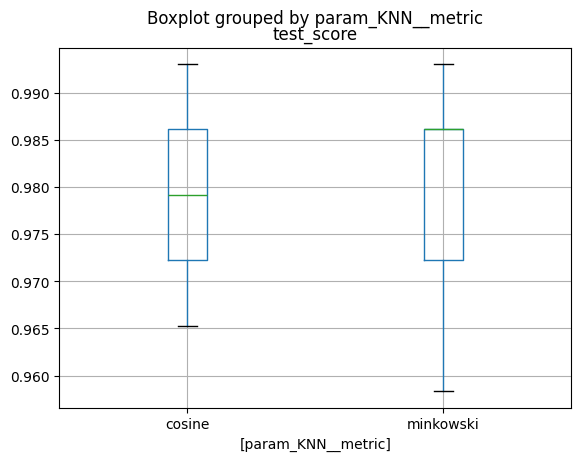

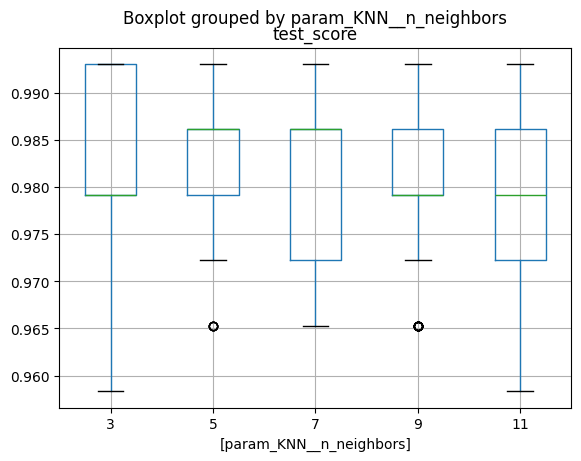

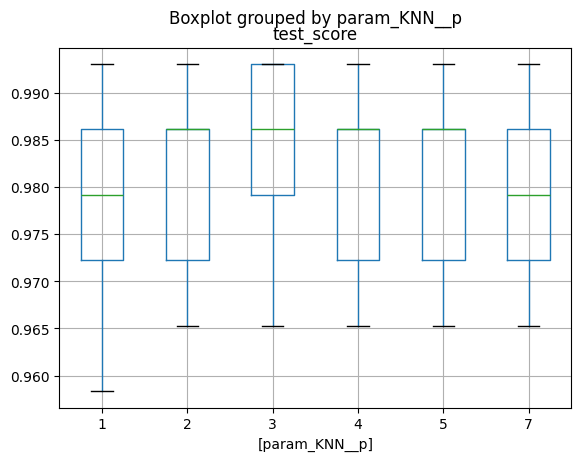

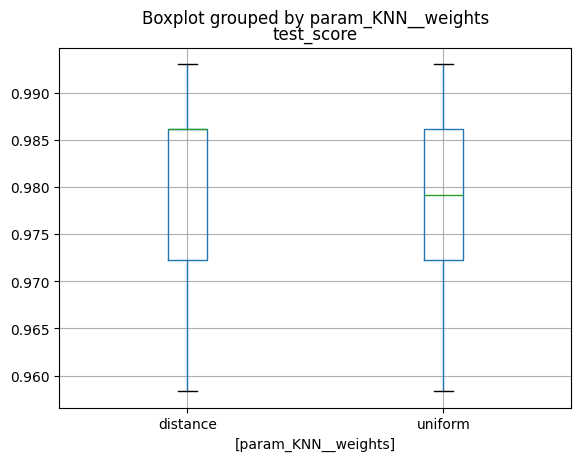

In [20]:
# Which parameter was more relevant for results improving?
results_df = pd.DataFrame(big_gscv.cv_results_)
summary_results_df = results_df.drop(columns = ['mean_fit_time','std_fit_time','mean_score_time','std_score_time','params','mean_test_score','std_test_score','rank_test_score'])
id_vars = ['param_KNN__metric','param_KNN__n_neighbors','param_KNN__p','param_KNN__weights']
value_vars = ['split0_test_score','split1_test_score','split2_test_score','split3_test_score','split4_test_score']
stacked_df = pd.melt(summary_results_df, id_vars=id_vars, value_vars=value_vars,
                     var_name='test_split', value_name='test_score')
params = ['param_KNN__metric','param_KNN__n_neighbors','param_KNN__p','param_KNN__weights']
for p in params:
    stacked_df.boxplot(by=p)
#results_df.boxplot(by='param_metric');

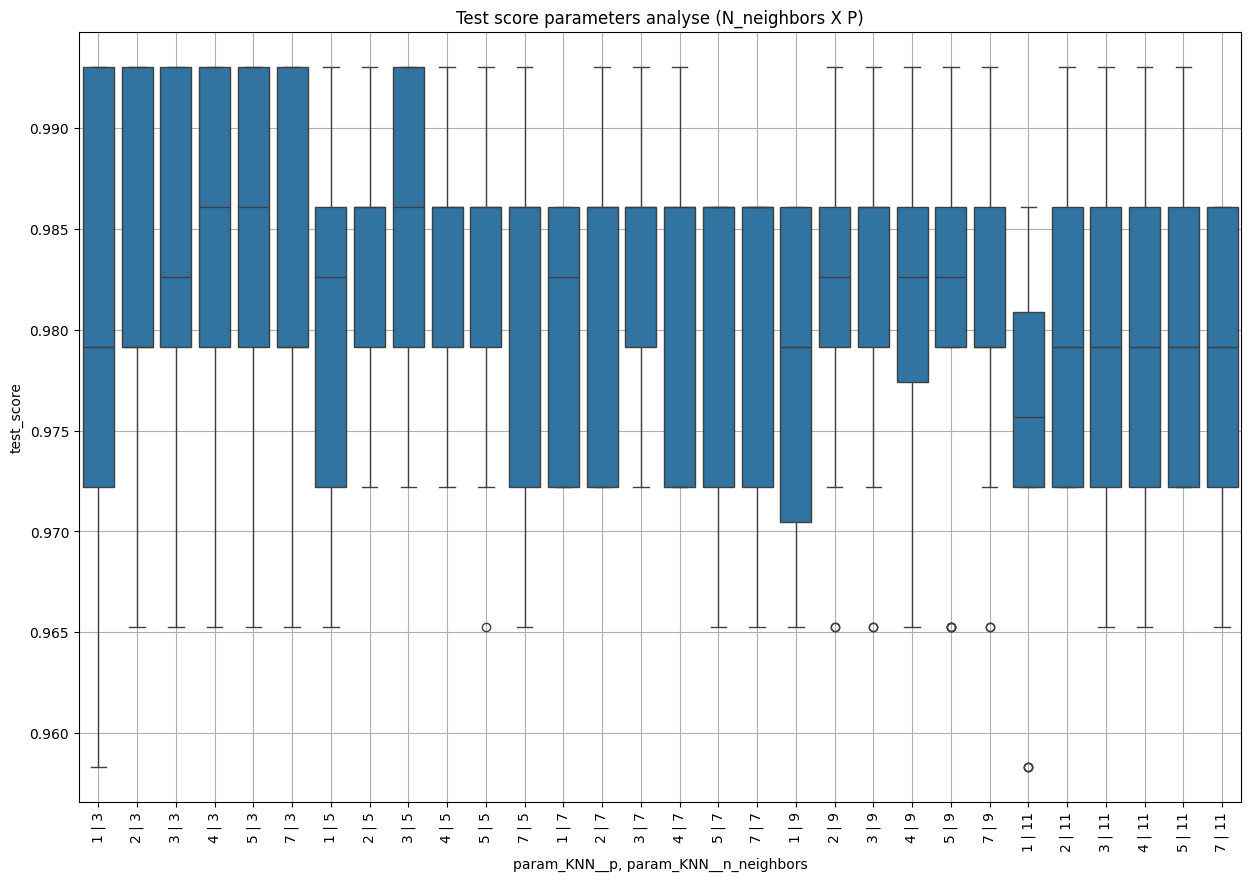

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def create_multi_level_boxplot(df, x_columns, y_column, title='Boxplot', yaxis_title=None, xaxis_title=None):
    """
    Creates a two-level boxplot for any given DataFrame using Matplotlib.

    Parameters:
    - df: pandas DataFrame containing the data.
    - x_columns: List of column names to use for grouping on the x-axis. Can be one or more.
    - y_column: Column name for the y-axis variable.
    - title: Plot title.
    - yaxis_title: Title for the Y-axis.
    - xaxis_title: Title for the X-axis (if not provided, concatenates x_columns names).
    """
    
    # Check if we need to create a combined group column
    if len(x_columns) > 1:
        df['Combined Group'] = df[x_columns].apply(lambda row: ' | '.join(row.values.astype(str)), axis=1)
        x_col = 'Combined Group'
    else:
        x_col = x_columns[0]
    
    # Define axis titles if not provided
    if not yaxis_title:
        yaxis_title = y_column
    if not xaxis_title:
        xaxis_title = ', '.join(x_columns)
    
    # Create a boxplot
    plt.figure(figsize=(15, 10))
    sns.boxplot(x=x_col, y=y_column, data=df)
    
    # Customize the plot
    plt.title(title)
    plt.xlabel(xaxis_title)
    plt.ylabel(yaxis_title)
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability if needed
    plt.grid()
    plt.show()

create_multi_level_boxplot(stacked_df.drop(columns='param_KNN__weights'), ['param_KNN__p','param_KNN__n_neighbors'], 'test_score', title='Test score parameters analyse (N_neighbors X P)')

In [22]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
%matplotlib qt

scaler = MinMaxScaler()
Xtr_norm = pd.DataFrame(scaler.fit_transform(Xtrain),columns=Xtrain.columns)

scaler_train = MinMaxScaler()
Xtest_norm = pd.DataFrame(scaler_train.fit_transform(Xtest),columns=Xtest.columns)

big_best_model = big_gscv.best_estimator_

ypred = big_best_model.predict(Xtest)

pca = PCA(n_components=3)

Xtr_norm_pca = pca.fit_transform(Xtr_norm)
Xtest_norm_pca = pca.transform(Xtest_norm)

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(
    Xtest_norm_pca[:, 0], Xtest_norm_pca[:, 1], Xtest_norm_pca[:, 2], c=ypred, s=50
);

In [23]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3)

Xtest_norm_tsne = tsne.fit_transform(Xtest_norm)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(Xtest_norm_tsne[:,0],Xtest_norm_tsne[:,1],Xtest_norm_tsne[:,2],c=ypred,s=50);